**Importing the Libraries**

In [7]:
# Install the required libraries.
!pip install opencv-python-headless
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-_rn5yfy6/pafy_6e3c719e19d04028a3012b7cfba071b2
  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git /tmp/pip-install-_rn5yfy6/pafy_6e3c719e19d04028a3012b7cfba071b2
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py) ... done


In [8]:
# Import the required libraries.
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
import cv2
import math
import random
import numpy as np
import PIL
import io
import html
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [9]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [10]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Preprocessing the Dataset**

In [11]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the dataset.
DATASET_DIR = "/content/drive/MyDrive/S2S Videos"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["101" , "500" , "7" ,  "Ada" , "Api Okkoma" , "Bandagini" , "Bus Eka" , "Class Room"  , "Colombo"  , "D"  , "Da?"  , "Denawa"  , "Enawa"  , "Galle"  , "Good Morning"  , "Hamuwenna"  , "Kanawa"  , "Keeyada"  , "Keeyatda"  , "Kiyanawa"  , "Koheda"  , "Kohomada"  , "Mage"  , "Mango"  , "Mata"  , "Meka"  , "Mokakda"  , "Oluwa Ridenawa"  , "Oyage"  , "Oyata"  , "Paan"  , "Police"  , "Principal"  , "Rasnaya"  , "Rugger"  , "Sellam Karanawa"  , "Sulanga"  , "Thank You"  , "Wadi"  , "Wattam"  , "Wed"  , "Yana"  , "school" ]

**Function to Normalize Frames**

In [12]:
def frames_extraction(video_path):
    '''This function extracts, resizes, and normalizes frames from a video. It takes the video's disk path as input and returns a list of processed frames.'''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

**Function to create Dataset**

In [13]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [14]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: 101
Extracting Data of Class: 500
Extracting Data of Class: 7
Extracting Data of Class: Ada
Extracting Data of Class: Api Okkoma
Extracting Data of Class: Bandagini
Extracting Data of Class: Bus Eka
Extracting Data of Class: Class Room
Extracting Data of Class: Colombo
Extracting Data of Class: D
Extracting Data of Class: Da?
Extracting Data of Class: Denawa
Extracting Data of Class: Enawa
Extracting Data of Class: Galle
Extracting Data of Class: Good Morning
Extracting Data of Class: Hamuwenna
Extracting Data of Class: Kanawa
Extracting Data of Class: Keeyada
Extracting Data of Class: Keeyatda
Extracting Data of Class: Kiyanawa
Extracting Data of Class: Koheda
Extracting Data of Class: Kohomada
Extracting Data of Class: Mage
Extracting Data of Class: Mango
Extracting Data of Class: Mata
Extracting Data of Class: Meka
Extracting Data of Class: Mokakda
Extracting Data of Class: Oluwa Ridenawa
Extracting Data of Class: Oyage
Extracting Data of Class: Oyata
Extra

In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

**Splitting the Data into Train & Test**

In [16]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)


**Constructing the Hybrid Model**(CNN+LSTM[ConvLSTM])

In [17]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [18]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

**Checking the Models Structure**

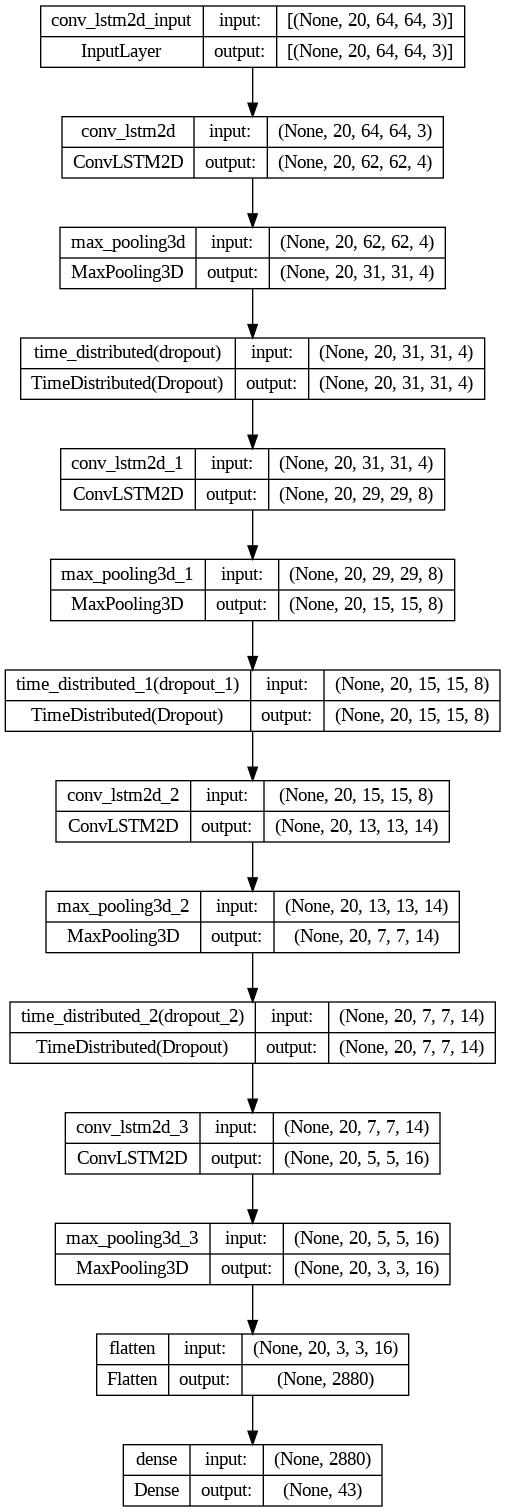

In [19]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Compiling & Training the Model**

In [20]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 40, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/40
364/364 [==============================] - 215s 555ms/step - loss: 3.7585 - accuracy: 0.0309 - val_loss: 3.7062 - val_accuracy: 0.0495
Epoch 2/40
364/364 [==============================] - 196s 537ms/step - loss: 3.5794 - accuracy: 0.0928 - val_loss: 3.3675 - val_accuracy: 0.1401
Epoch 3/40
364/364 [==============================] - 194s 534ms/step - loss: 2.9010 - accuracy: 0.2338 - val_loss: 2.8831 - val_accuracy: 0.2747
Epoch 4/40
364/364 [==============================] - 194s 534ms/step - loss: 2.1127 - accuracy: 0.4319 - val_loss: 2.5739 - val_accuracy: 0.3434
Epoch 5/40
364/364 [==============================] - 193s 531ms/step - loss: 1.4317 - accuracy: 0.6032 - val_loss: 2.3349 - val_accuracy: 0.4313
Epoch 6/40
364/364 [==============================] - 194s 534ms/step - loss: 0.9409 - accuracy: 0.7235 - val_loss: 2.2173 - val_accuracy: 0.5714
Epoch 7/40
364/364 [==============================] - 195s 535ms/step - loss: 0.6349 - accuracy: 0.8253 - val_loss: 1.9021 -

**Evaluating the Trained Model**

In [21]:
 # Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

19/19 [==============================] - 7s 298ms/step - loss: 1.8917 - accuracy: 0.6056


**Saving the Model**

In [23]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)


**Plotting the Models Loss & Accuracy Curves**

In [24]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

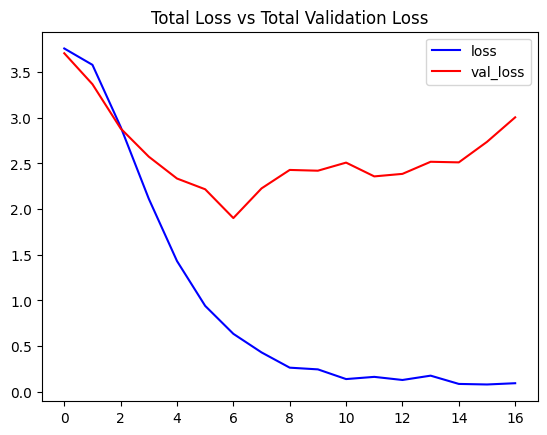

In [25]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

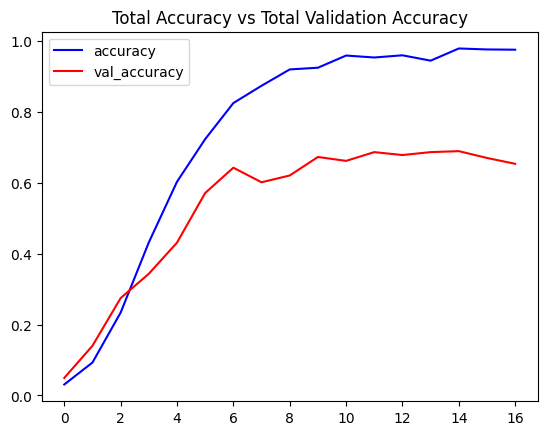

In [26]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**Constructing the LRCN Model**

In [27]:
#construct the model
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [28]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

**Checking the Models Structure**

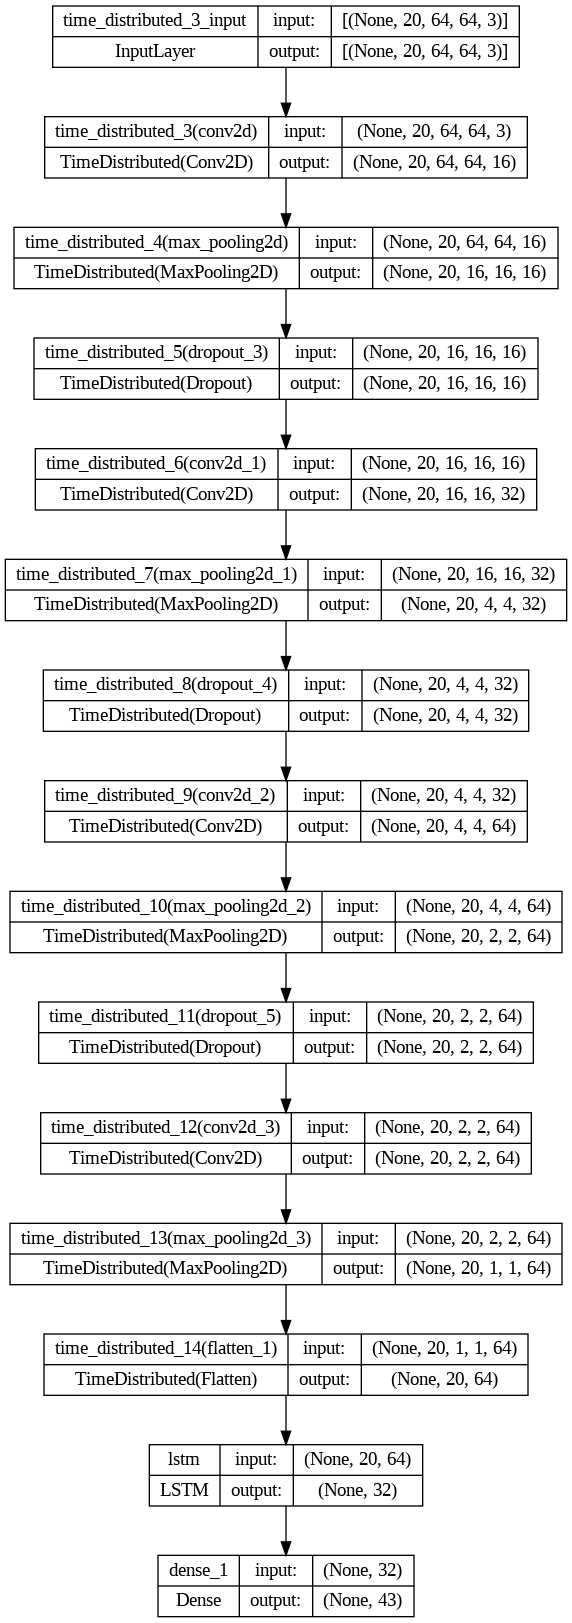

In [29]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Compiling & Training the Model**

In [30]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
364/364 [==============================] - 14s 31ms/step - loss: 3.7639 - accuracy: 0.0165 - val_loss: 3.7581 - val_accuracy: 0.0302
Epoch 2/50
364/364 [==============================] - 10s 28ms/step - loss: 3.7593 - accuracy: 0.0289 - val_loss: 3.7566 - val_accuracy: 0.0165
Epoch 3/50
364/364 [==============================] - 10s 28ms/step - loss: 3.7553 - accuracy: 0.0275 - val_loss: 3.7546 - val_accuracy: 0.0247
Epoch 4/50
364/364 [==============================] - 10s 27ms/step - loss: 3.7488 - accuracy: 0.0268 - val_loss: 3.7525 - val_accuracy: 0.0165
Epoch 5/50
364/364 [==============================] - 10s 27ms/step - loss: 3.7316 - accuracy: 0.0371 - val_loss: 3.7594 - val_accuracy: 0.0165
Epoch 6/50
364/364 [==============================] - 10s 28ms/step - loss: 3.6864 - accuracy: 0.0426 - val_loss: 3.8143 - val_accuracy: 0.0275
Epoch 7/50
364/364 [==============================] - 10s 26ms/step - loss: 3.5940 - accuracy: 0.0502 - val_loss: 3.5813 - val_accuracy:

**Evaluating the Trained Model**

In [31]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

19/19 [==============================] - 2s 70ms/step - loss: 2.1061 - accuracy: 0.5578


**Saving the Model**

In [32]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

modelfilename = '/lib/newmodel.h5'

**Plotting the Models Loss & Accuracy Curves**


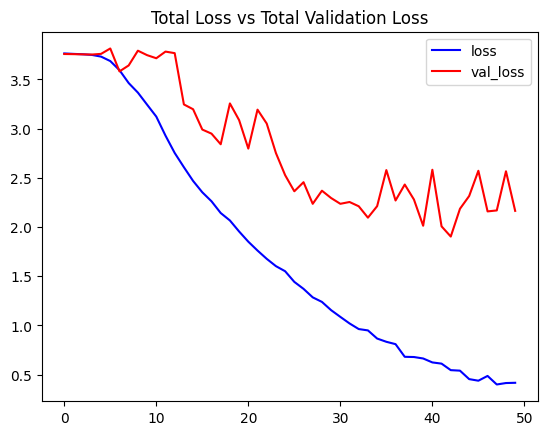

In [33]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

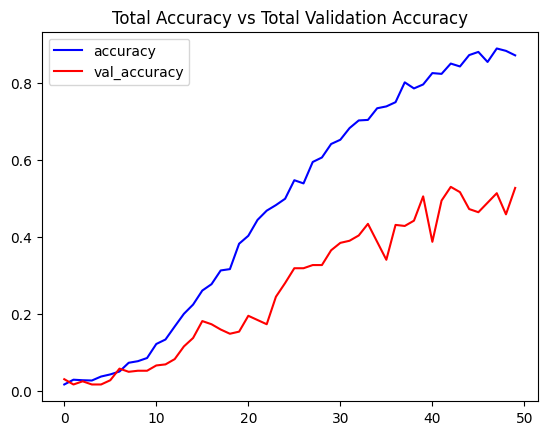

In [34]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**Inserting a Test Video to check the Performace of the model**

In [42]:


# Specify the path to your video in Google Drive (replace with your actual path)
video_path_in_drive = '/content/drive/MyDrive/Test Videos/Movie on 2024-03-25 at 2.37 AM #3.mov'

# Define the input video file path based on the mounted Drive
input_video_file_path = video_path_in_drive




**Creating a Function to perform Gesture Recognition**



In [43]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    # Declare a queue to store video frames.def predict_on_video(video_path_in_drive, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform gesture recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_path_in_drive)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

**Predicting output on Test Video**

In [44]:
# Define the output video directory.
output_video_directory = os.path.dirname(video_path_in_drive)

# Construct the output video path.
output_video_file_path = f'{output_video_directory}/{os.path.splitext(os.path.basename(video_path_in_drive))[0]}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)



# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 27ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  87%|████████▋ | 104/120 [00:00<00:00, 341.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Test Videos/Movie on 2024-03-25 at 2.37 AM #3-Output-SeqLen20.mp4, 405000 bytes wanted but 0 bytes read,at frame 119/120, at time 3.97/3.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


**Saving the Combined Model as One**

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate

# Assuming you have already defined and trained your ConvLSTM model
# convlstm_model = create_convlstm_model()

# Assuming you have already defined and trained your LRCN model
# lrcn_model = create_LRCN_model()

# Define inputs for both models
convlstm_input = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
lrcn_input = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Get output from each model
convlstm_output = convlstm_model(convlstm_input)
lrcn_output = LRCN_model(lrcn_input)

# Concatenate the outputs
combined_output = Concatenate()([convlstm_output, lrcn_output])

# Define the combined model
combined_model = Model(inputs=[convlstm_input, lrcn_input], outputs=combined_output)

# Compile the combined model
combined_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Save the combined model
combined_model.save('/content/drive/MyDrive/S2Ssavedmodel/combined_model.h5')







**Loading the final Model**

In [46]:
from tensorflow.keras.models import load_model

# Load the combined model
combined_model = load_model('/content/drive/MyDrive/S2Ssavedmodel/combined_model.h5')

# Now you can use the combined_model for inference
combined_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_2 (InputLayer)           [(None, 20, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, 43)           156883      ['input_1[0][0]']                
                                                                                              

In [48]:
from tensorflow.keras.models import load_model

# Load the combined model
combined_model = load_model('/content/drive/MyDrive/S2Ssavedmodel/combined_model.h5')

# Print the summary of the loaded model
combined_model.summary()

# Test the model with some sample input data (e.g., a single sequence of frames)
# Ensure that the input data shape matches the input shape of your model
# You can use random data or a small subset of your dataset for testing
test_input_data = '/content/drive/MyDrive/Test Video/final.mov'
predicted_output = combined_model.predict(test_input_data)

# Evaluate the model on a validation set
# Ensure that the validation data matches the input and output shapes expected by your model
validation_loss, validation_accuracy = combined_model.evaluate(validation_data)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_2 (InputLayer)           [(None, 20, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, 43)           156883      ['input_1[0][0]']                
                                                                                              

IndexError: tuple index out of range